# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [5]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print("------")
print(brain)

BananaBrain
------
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
env.brain_names

['BananaBrain']

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [9]:
action_size

4

In [10]:
state_size

37

In [11]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [12]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [3]:
import torch
import time
import random
import numpy as np
from collections import deque
from dqn_agent import *
from model import *
from unityagents import UnityEnvironment

In [4]:
num_episodes=2000
epsilon=1.0
epsilon_min=0.05
epsilon_decay=0.99
scores = []
scores_average_window=100
required_score = 14

In [5]:
def get_environment_info(location):
    '''To get the information about the environment from the given location of Unity ML agent'''
    env = UnityEnvironment(location)
    # We check for the first brain available, and set it as the default brain, we will be controlling using Python API.
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    # action size is the total number of distinct actions.
    action_size = brain.vector_action_space_size
    # state size is the total number of dimensions of the each state in the environment. In our case, it's 37.
    state_size = brain.vector_observation_space_size

    return (env, brain_name, brain, action_size, state_size)


def get_agent(state_size, action_size, dqn_type):
    '''Initializes and returns the agent'''
    agent = Agent(state_size=state_size, action_size=action_size, dqn_type=dqn_type)
    print(f"Agent has been initialized with dqn_type as {dqn_type}...")
    return agent


def train_agent(env, brain_name, brain, action_size, state_size, agent, epsilon, dqn_type,num_episodes):
    '''Trains the agent
        
        Input parameters:
        brain_name: the name of the first brain available.
        brain: The policy that we train.
        action_size: Total number of actions that an agent can take.
        state_size: 37 dimension (in this navigation case)
        epsilon: This is used for epsilon-greedy action selection.
        num_episodes: Total number of episodes to train the agent.


    '''
    print(brain_name)

    '''
    1. Reset the training environment at the beginning of each episode.
    2. Get the current state i.e., s
    3. Use Epsilon-greedy policy to perform and action(a), in the environment in the given state (s)
    4. Get the reward and next_state of the environment for action (a)
    5. Calcuate the error between actual and expeted Q values for s(t), a(t), r(t), s(t+1), in turn this is used to train Neural Networks
    6. Update the total reward received and set s(t) <- s(t+1)
    7. Steps 1 to 3 will be repeated until the episode is done.


    However, in the case below the training process stops even if the total score of agent > 14.
    '''


    for i_episode in range(1, num_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]

        # initial state
        state = env_info.vector_observations[0]

        # Initial score for each episode is 0.
        score = 0

        while True:
            # get the action.
            action = agent.act(state, epsilon)

            # take the action in the environment
            env_info = env.step(action)[brain_name]

            # now get the next state of the environment, post taking the action.
            next_state = env_info.vector_observations[0]

            # reward from the environment after action (a)
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break


        # After every episode, append score to the scores list, calculate the mean.
        scores.append(score)

        # mean score is calcuated over present episode until i_episode > 100. 
        # (so past 100 scores will be taken for average if they available, else all the existing score will be used for mean)
        average_score = np.mean(scores[i_episode - min(i_episode, scores_average_window): i_episode+1])

        # epsilon value is being reduced as the agent is learning and action space can exploited.
        epsilon = max(epsilon_min, epsilon_decay*epsilon)

        print(f"Episode: {i_episode} , Average Score: {round(average_score, 4)}")

        # Print average score every scores_average_window episodes
        if i_episode % scores_average_window == 0:
            print(f"Average score after {i_episode} episode is {round(average_score, 4)}")
            print('------------------------------------------------------------')
        
        # Check to see if the task is solved (i.e,. avearge_score > required_score). 
        # If yes, save the network weights and scores and end training.
        if average_score >= required_score:
            print('\n{} Agent has learnt to solve the environment in {:d} episodes!\tAverage Score: {:.2f}'.format(dqn_type,i_episode, average_score))

            #  To save the weights of the Neural network
            start_time = time.strftime("%Y%m%d-%H%M%S")
            network_name = "saved_models/"+dqn_type+"model_weights_"+start_time + ".pth"
            torch.save(agent.network.state_dict(), network_name)
            print(f"Saved the {dqn_type} model weights at {network_name}")

            # To save the recorded Scores data.
            scores_filename = "scores/"+dqn_type+"_agent_scores_"+start_time + ".csv"
            np.savetxt(scores_filename, scores, delimiter=",")
            print(f"Scores of the training process for {dqn_type} model has been stored at {scores_filename}")
            break

    # close the environment after all the episodes.
    env.close()
    print("Closed the environment")

In [6]:
# Load the environment
location = "Banana_Windows_x86_64/Banana.exe"
env, brain_name, brain, action_size, state_size = get_environment_info(location)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
agent = get_agent(state_size, action_size, "DQN")

Agent has been initialized with dqn_type as DQN...


In [8]:
train_agent(env, brain_name, brain, action_size, state_size, agent, epsilon, "DQN", num_episodes )

BananaBrain
Episode: 1 , Average Score: 0.0
Episode: 2 , Average Score: 1.0
Episode: 3 , Average Score: 0.6667
Episode: 4 , Average Score: 0.25
Episode: 5 , Average Score: 0.2
Episode: 6 , Average Score: 0.1667
Episode: 7 , Average Score: 0.1429
Episode: 8 , Average Score: 0.25
Episode: 9 , Average Score: -0.1111
Episode: 10 , Average Score: -0.1
Episode: 11 , Average Score: -0.2727
Episode: 12 , Average Score: -0.25
Episode: 13 , Average Score: -0.0769
Episode: 14 , Average Score: -0.1429
Episode: 15 , Average Score: -0.1333
Episode: 16 , Average Score: -0.0625
Episode: 17 , Average Score: -0.1765
Episode: 18 , Average Score: -0.3333
Episode: 19 , Average Score: -0.4211
Episode: 20 , Average Score: -0.3
Episode: 21 , Average Score: -0.2381
Episode: 22 , Average Score: -0.2273
Episode: 23 , Average Score: -0.2174
Episode: 24 , Average Score: -0.2083
Episode: 25 , Average Score: -0.16
Episode: 26 , Average Score: -0.0385
Episode: 27 , Average Score: -0.037
Episode: 28 , Average Score: 0

Episode: 228 , Average Score: 9.64
Episode: 229 , Average Score: 9.6
Episode: 230 , Average Score: 9.71
Episode: 231 , Average Score: 9.85
Episode: 232 , Average Score: 9.91
Episode: 233 , Average Score: 9.9
Episode: 234 , Average Score: 10.07
Episode: 235 , Average Score: 10.07
Episode: 236 , Average Score: 10.18
Episode: 237 , Average Score: 10.24
Episode: 238 , Average Score: 10.27
Episode: 239 , Average Score: 10.35
Episode: 240 , Average Score: 10.38
Episode: 241 , Average Score: 10.44
Episode: 242 , Average Score: 10.51
Episode: 243 , Average Score: 10.53
Episode: 244 , Average Score: 10.51
Episode: 245 , Average Score: 10.46
Episode: 246 , Average Score: 10.51
Episode: 247 , Average Score: 10.5
Episode: 248 , Average Score: 10.49
Episode: 249 , Average Score: 10.49
Episode: 250 , Average Score: 10.48
Episode: 251 , Average Score: 10.47
Episode: 252 , Average Score: 10.5
Episode: 253 , Average Score: 10.46
Episode: 254 , Average Score: 10.56
Episode: 255 , Average Score: 10.51
Ep

Episode: 451 , Average Score: 13.88
Episode: 452 , Average Score: 13.84
Episode: 453 , Average Score: 13.79
Episode: 454 , Average Score: 13.82
Episode: 455 , Average Score: 13.91
Episode: 456 , Average Score: 13.91
Episode: 457 , Average Score: 13.9
Episode: 458 , Average Score: 13.89
Episode: 459 , Average Score: 13.87
Episode: 460 , Average Score: 13.89
Episode: 461 , Average Score: 13.85
Episode: 462 , Average Score: 13.91
Episode: 463 , Average Score: 13.86
Episode: 464 , Average Score: 13.84
Episode: 465 , Average Score: 13.83
Episode: 466 , Average Score: 13.84
Episode: 467 , Average Score: 13.86
Episode: 468 , Average Score: 13.77
Episode: 469 , Average Score: 13.75
Episode: 470 , Average Score: 13.71
Episode: 471 , Average Score: 13.73
Episode: 472 , Average Score: 13.63
Episode: 473 , Average Score: 13.58
Episode: 474 , Average Score: 13.55
Episode: 475 , Average Score: 13.63
Episode: 476 , Average Score: 13.68
Episode: 477 , Average Score: 13.67
Episode: 478 , Average Score:

## Plotting

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import chain
import os

In [11]:
def get_csv_files():
    files = os.listdir()
    files = list(filter(lambda f: f.endswith('.csv'), files))
    return files

In [12]:
files = get_csv_files()

In [17]:
def make_plot(file):
    df = pd.read_csv(file)
    y_ = list(chain(*df.iloc[0:].values.tolist()))
    x_ = [i for i in range(len(y_))]
        
    scores_average_window = 100
    avg_scores = []
    for i_episode in range(len(x_)):
        average_score = np.mean(y_[i_episode - min(i_episode, scores_average_window): i_episode+1])
        avg_scores.append(average_score)
    
    avg_scores_ = np.array(avg_scores)
    amax = np.where(avg_scores_ > 13)
    
    plt.plot(x_, y_, 'g', alpha=0.3)
    plt.plot(x_, avg_scores, 'g')
    amax = amax[0][0]
    x_lim, y_lim = plt.xlim(), plt.ylim()
    plt.plot([x_[amax], x_[amax], x_lim[0]], [x_lim[0], avg_scores[amax], avg_scores[amax]],
            linestyle='--')
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel('Episodes')
    plt.ylabel('Average Score over 100 episodes')

    #plt.savefig("img.jpg")
    plt.show()

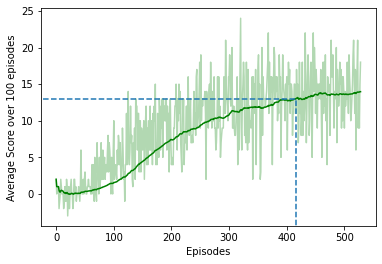

In [20]:
file_name = "DQN_agent_scores_20210725-200915.csv"
make_plot(file_name)